# Portfolio Optimization : Markowitz Model
<b> <hr>


<center> 
<b> BOUDCHICHI Oussama

<b> <hr>
<b> <hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(10,8)
plt.style.use('seaborn-whitegrid')
import cvxopt as cvx
from functools import reduce 
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import LedoitWolf as LW
import datetime as dt
from termcolor import colored

## Quadratic Optimization : 

cvxopt is a python library that solve quadratic optimization programs.

A quadratic convex optimization program (QP) is written in standard form as : $$
 \left\{
    \begin{array}{ll}
        \underset{x}{\text{min}} & \frac{1}{2}x'Px+q'x\\
        \text{s.t} & Gx \leq h \\
         & Ax=b \\
    \end{array}
\right. $$

Where : $$ P\in \mathcal{S}_n({\mathbb{R}}) \ ;\  \ x,q \in \mathcal{M}_{n,1}(\mathbb{R})   \ ;\ \ G \in \mathcal{M}_{m,n}(\mathbb{R})\ ;\  h\in \mathcal{M}_{m,1}(\mathbb{R})$$

 $$ A\in \mathcal{M}_{s,n}(\mathbb{R}) \ ;\ \ b\in \mathcal{M}_{s,1}(\mathbb{R}) $$

 Note that, if P is not symmetric, then it can be decomposed as  :
  $$ P=S+A $$
with S (resp. A) is the symmetric (resp. Anti-symmetric) part of P. These decomposition is due to the fact that : $$\mathcal{M}_n(\mathbb{R})=\mathcal{S}_n(\mathbb{R})\bigoplus \mathcal{A}_n(\mathbb{R})$$
 for $X \in \mathcal{M}_{n,1}(\mathbb{R})$ : $$X'PX=X'SX+X'AX$$
Since : 
$$(X'AX)'=-X'AX \ \Leftrightarrow X'AX=0$$
Thus: $$X'PX=X'SX$$ 
 
* The objective quadratic function  f is defined as (for all x that satisfies the constraints) :
$$ f(x)=\frac{1}{2}x'Px+q'x$$  f has a unique global minimum if P is Symmetric Positive-Definite

For further information, the reader can see : 
 
 * https://www.math.uh.edu/~rohop/fall_06/Chapter3.pdf

 * https://ocw.mit.edu/courses/sloan-school-of-management/15-084j-nonlinear-programming-spring-2004/lecture-notes/lec4_quad_form.pdf

In [2]:
# cvxopt.solvers.qp() assumes that we provide a symmetric cost matrix. so we need to wrap it :

def cvx_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P=0.5*(P+P.T)
    args=[cvx.matrix(P, tc='d'), cvx.matrix(q, tc='d')]
    if G is not None : 
        args.extend([cvx.matrix(G, tc='d'), cvx.matrix(h, tc='d')])
        if A is not None : 
            args.extend([cvx.matrix(A, tc='d'), cvx.matrix(b, tc='d')])
    sol=cvx.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    
    
    sol_1={'x': np.array(sol['x']).reshape((P.shape[1],)), 'min_f': 2*sol['primal objective']}
    return sol_1

In [3]:
# example : 
P_test=np.array([[3,0], [1,4]], dtype=float)
G_test=np.array([[0.2, 0.4]])
h_test=np.array([3], dtype=float)
q_test=np.array([0, 0], dtype=float)

In [4]:
cvx_solve_qp(P=P_test, q=q_test, G=G_test, h=h_test)

     pcost       dcost       gap    pres   dres
 0:  1.9540e-01 -2.6681e+00  3e+00  8e-17  2e+00
 1:  1.2931e-05 -2.9976e-02  3e-02  1e-16  1e-02
 2:  1.2931e-09 -3.0000e-04  3e-04  1e-17  1e-04
 3:  1.2931e-13 -3.0000e-06  3e-06  1e-16  1e-06
 4:  1.2931e-17 -3.0000e-08  3e-08  1e-16  1e-08
Optimal solution found.


{'x': array([1.18952193e-09, 2.18079020e-09]), 'min_f': 2.586236867577293e-17}

In [5]:
# if you don't want the function to show progress, then type : 
cvx.solvers.options['show_progress']=False

## Portfolio Optimization : 

In the mean-variance Portfolio problem, (in the absence of a risk-free asset) investors seek to minimize the variance of the portfolio (risk) for a given expected return (Which is the case we present here), or maximize the expected return for a given risk level. This problem is equivalent to a QP, given as : $$
 \left\{
    \begin{array}{ll}
        \underset{\omega}{\text{min}} & \frac{1}{2}\omega'\Sigma\omega\\
        \text{s.t} & \mu'\omega \geq m \\
         & \mathbf{1}_n'\omega=1 \\
    \end{array}
\right. $$
Where : 

* $\omega$ is the vector of the risky assets weights ; 

* $\Sigma$ is the variance-covariance matrix of the random vector of risky assets annual returns;

* $\mu$ is the vetor of expected assets returns (Mathematically if R is the vector of the risky assets returns, then $\mu=\mathbb{E}(R)$); 


* $\mathbf{1}_n=(1,\dots, 1)'$;

* m is a given  portfolio's expected return;


Note that, solving this problem requires estimations of $\mu$ and $\Sigma$ based on historical data. 

Assuming we have an i.i.d sample  $(R_1,\dots, R_T)\sim\mathcal{N}_n(\mu,\Sigma)$, the MLE of $\mu$ and $\Sigma$ are : 
$$\hat{\mu}=\overline{R} \ \ ;\ \ \ \  \widehat{\Sigma}=\frac{1}{T}\sum_{t=1}^{T}(R_t-\overline{R})(R_t-\overline{R})'$$
Since the ML estimator of $\Sigma$ is biased, one might consider the unbiased estimator : $$ S=\frac{T}{T-1}\widehat{\Sigma}$$

Althought These estimators are unbiased, their  main disadvantage  is the fact that they contain a lot of estimation error when the number of data points is of comparable or even smaller order than the number of individual stocks. Sometimes, S can be singular or nummerically ill-conditionned, which means that inverting it amplifies estimation error tremendously.

That's why we'll use the James-Stein Estimator for $\mu$, And The Ledoit-Wolf Shrinkage estimator for $\Sigma$.

For futher information, the reader can check : 

* http://www.ledoit.net/ole2.pdf

* http://www.ledoit.net/honey.pdf

*  https://yao-lab.github.io/2020.csic5011/slides/Lecture03_JSE.pdf

* https://matheo.uliege.be/bitstream/2268.2/6981/4/Memoire_Tom_Demaret.pdf



**The Ledoit-Wolf** estimator of $\Sigma$ can be written as : 
$$\widehat{\Sigma}_{\text{shrink}}=(1-\alpha)\widehat{\Sigma}+\alpha\frac{Tr(\widehat{\Sigma})}{n}I_n$$
Where $\alpha$ is the shrinkage parameter that minimizes the MSE (in the sense of the Frobenuis-Norm) between the estimated and real covariance matrix. It amounts to setting the bias/variance trade-off. 

Ledoit-Wolf estimator is already implemented in python's package sklearn.covariance along with a better version of this estimator called the OAS estimator \[1].

\[1] Chen et al. derived a formula aimed at choosing a shrinkage coefficient that yields a smaller Mean Squared Error than the one given by Ledoit and Wolf’s formula. The resulting estimator is known as the Oracle Shrinkage Approximating estimator of the covariance. The reader can check : *Chen et al., “Shrinkage Algorithms for MMSE Covariance Estimation”, IEEE Trans. on Sign. Proc., Volume 58, Issue 10, October 2010*.


**The James-Stein** estimator can be written as (Under multivariate normality assumption) : 

$$\forall \ n\geq 3\ \ \  \hat{\mu}_{\text{JS}}=(1-\frac{n-2}{(T-n+3)\overline{R}'S^{-1}\overline{R}})\overline{R}$$

Note that this Estimator can be generalized for all elliptically symmetric distributions.

In [6]:
# Let's define a function that compute the J-SE : 
def JS(R, n, T, vcov):
    assets=R.columns
    R_mean=np.array(R.mean()).reshape(n,1)
    vcov_inv=np.linalg.inv(vcov)
    x=(T-n+3)*np.dot(np.dot(R_mean.T, vcov_inv), R_mean)
    y=(n-2)/x
    js=(1-y)*R_mean

    return pd.Series(js.T[0], index=assets)

** Portfolio description**

Our Portfolio consists of 6 stocks (**BCP, ATLANTASANAD, Maroc Telecom, SOTHEMA, Attijariwafabank, COSUMAR**) traded at Casablanca Stock Exchange. The historical data consist of stocks returns over one period of 5 years (from 2016-01-01 to 2020-12-31).

Historical Data (Closing prices) is retrieved from https://www.leboursier.ma/. In order to do that, let's build a web scaping algorithm


In [7]:
stocks={'BCP-P':'BCP','ATLANTA-P':'ATLANTASANAD', 'Maroc-Telecom':'MarocTelecom', 'SOTHEMA':'SOTHEMA','Attijariwafa-Bank':'AttijariwafaB', 'COSUMAR':'COSUMAR'}

In [8]:
data={}
for ticker, stock in stocks.items():
    link='https://www.leboursier.ma/details/action/'+ticker+'/historiques.html?date_from=2016-01-01&date_to=2020-12-31'
    req=requests.get(link)
    req_contents=BeautifulSoup(req.content, 'html.parser')
    table=req_contents.find('tbody', {'class':'table-body'}).find_all('tr')
    price_close=[]
    date=[]
    for i in range(len(table)):
        d=dt.datetime.strptime(table[i].find_all('td')[0].text, '%d/%m/%Y')
        date.append(d)
        price_close.append(float(table[i].find_all('td')[1].text.replace(",",".").replace(' ','')))
 
    a=pd.DataFrame({stock:price_close}, index=date)
    data[ticker]=a

In [9]:
# Now let's gather the historical data in one DataFrame
data_val=list(data.values())
data_df=reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True, how='outer'), data_val)
data_df.columns=stocks.values()

In [10]:
# Let's take a look at the number of trading days per year : 
tr_days_per_year=data_df['BCP'].groupby([data_df['BCP'].index.year]).agg('count')
tr_days_per_year=pd.DataFrame([tr_days_per_year], index=['All stocks (merged)'])
tr_days_per_year

,2016,2017,2018,2019,2020
All stocks (merged),172,250,247,246,250


Text(0.5, 1.0, 'The Closing Prices of all Stocks')

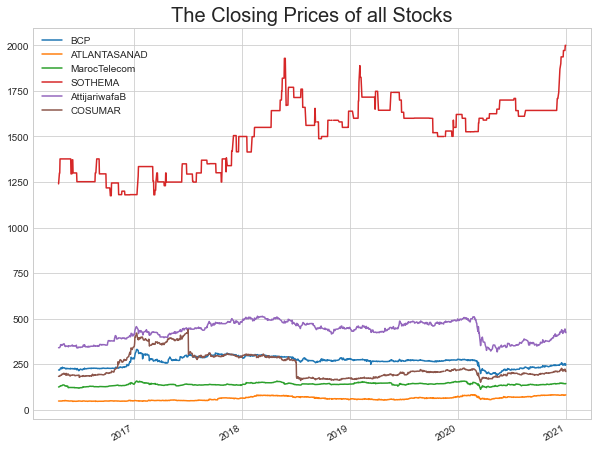

In [11]:
# Visualize the Closing prices for all stocks : 
data_df.plot()
plt.title('The Closing Prices of all Stocks', fontsize=20)

Text(0.5, 1.0, 'Log-rates of returns of all Stocks')

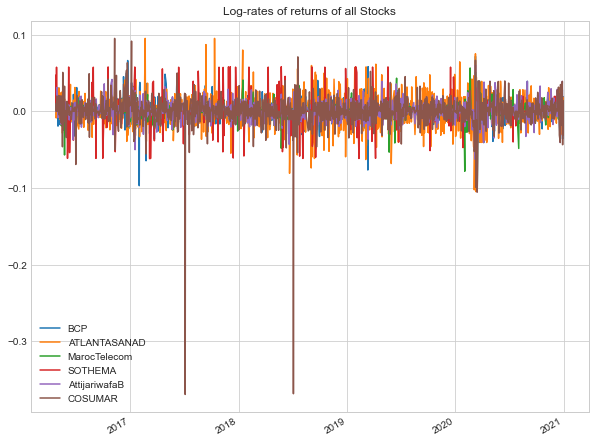

In [12]:
# Now let's plot the stocks log-rates of returns (Between Days) : 
log_ret=data_df.pct_change().apply(lambda x: np.log(1+x)).dropna()
log_ret.plot()
plt.title('Log-rates of returns of all Stocks')
# One can easily observe that log-rates of returns are  quite volatile

In [13]:
# Now let's Get the  Expected log-rates of returns of the Stocks, using the J-S Estimator : 
# Note : APR : Annual % Rate
APR=log_ret.groupby([log_ret.index.year]).agg('sum')
# Annual log-rates of returns
APR
# Annual Expected log-rates of returns
T=APR.shape[0]
n=len(APR.columns)
vcov=APR.cov() # In this case u can see that n > T, so the vcov is theoretically singular.
Expected_ret=JS(R=APR, T=T, n=n, vcov=vcov)
Expected_ret

BCP              0.026283
ATLANTASANAD     0.105237
MarocTelecom     0.028886
SOTHEMA          0.095607
AttijariwafaB    0.043187
COSUMAR          0.026530
dtype: float64

In [14]:
# The Ledoit-Wolf estimator of the vcov matrix can be obtained using LW().fit(data). let's wrap it : 
def LW_E(x):
    lw=LW().fit(x)
    df=pd.DataFrame(lw.covariance_, index=x.columns, columns=x.columns )
    return df

In [15]:
LW_vcov=LW_E(APR)
LW_vcov

,BCP,ATLANTASANAD,MarocTelecom,SOTHEMA,AttijariwafaB,COSUMAR
BCP,0.024640,-0.001113,0.003464,-0.005251,0.008234,0.021776
ATLANTASANAD,-0.001113,0.028199,-0.002355,0.002370,0.004691,0.008326
MarocTelecom,0.003464,-0.002355,0.018230,-0.004863,0.002490,0.008674
SOTHEMA,-0.005251,0.002370,-0.004863,0.022920,-0.003980,-0.016212
AttijariwafaB,0.008234,0.004691,0.002490,-0.003980,0.026164,0.018140
COSUMAR,0.021776,0.008326,0.008674,-0.016212,0.018140,0.102340


In [48]:
# Note : 
print("\033[1m"+colored('Determinant of the usual Sample vcov Estimator : ','red'),np.linalg.det(vcov))
print("\033[1m"+colored('Determinant of the Ledoit-Wolf Estimator : ','red'),np.linalg.det(LW_vcov))



Determinant of the usual Sample vcov Estimator :  2.055438242601919e-43
Determinant of the Ledoit-Wolf Estimator :  3.478249893111889e-10


Text(0.5, 1.0, 'Evolution of Annualized Volatilty')

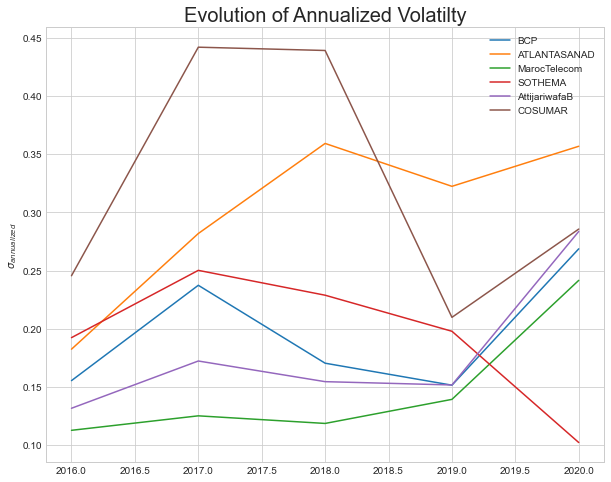

In [16]:
# Now let's graph the evolution of annualized volatilities : 
N=np.array(tr_days_per_year.T)
Volat=log_ret.groupby([log_ret.index.year]).agg('std')*np.sqrt(N)
Volat.plot()
plt.ylabel(r'$\sigma_{annualized}$')
plt.title('Evolution of Annualized Volatilty', fontsize=20)

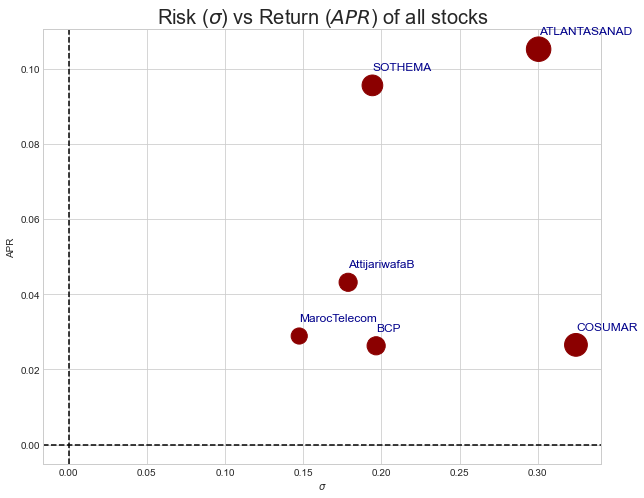

In [17]:
# Now let's plot the expected annual log-rate of return Vs annualized volatility : 
fig, ax=plt.subplots()
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('APR')
ax.set_title(r"Risk ($\sigma$) vs Return ($APR$) of all stocks", fontsize=20)
c=[y+x for y, x in zip(Expected_ret, Volat.mean())]
c=list(map(lambda x: x/max(c), c))
s=list(map(lambda x: x*600, c))
ax.scatter(Volat.mean(), Expected_ret, s=s, color='darkred')
ax.axhline(y=0, color='black', linestyle='dashed')
ax.axvline(x=0, color='black', linestyle='dashed')
for idx, instr in enumerate(list(Volat.columns)):
    ax.annotate(instr, (Volat.mean()[idx], Expected_ret[idx]+0.004), color='darkblue', fontsize=12)

# Notice that  SOTHEMA and ATLANTASANAD have similar expected annual log-rates of returns, but SOTHEMA's risk is lower than ATLANTASANAD. COSUMAR in the other hand, has very low expected log-rate of return but the biggest Risk.

**Portfolio Allocation**

In [18]:
# An example for a mimimum Portfolio's expected annual log-rate of return of : 9%
np.set_printoptions(precision=4)
P=LW_vcov.values
n=len(APR.columns) # number of Assets
A=np.ones(n).reshape(1,n)
x=-Expected_ret.values.reshape(1,n) # Note the minus
G=np.vstack([x, np.eye(n)])
port_expected=np.array([[-0.09]+[1]*n], dtype=float).reshape(n+1,1)
b=np.array([1.0])
q=np.zeros(n)
sol=cvx_solve_qp(P=P, q=q, G=G, A=A, b=b, h=port_expected)
sol

{'x': array([0.0175, 0.3994, 0.0947, 0.4538, 0.028 , 0.0065]),
 'min_f': 0.009584991462818179}

In [24]:
# Let's Contstruct the Portfolio frontier : 
mus=np.arange(0.0, 0.19,0.0001)
p_weights=[]
p_returns=[]
p_vol=[]
for mu in mus :
    exp_mu=np.array([[-mu]+[1]*n], dtype=float).reshape(n+1,1)
    sol=sol=cvx_solve_qp(P=P, q=q, G=G, A=A, b=b, h=exp_mu)
    p_weights.append(list(sol['x']))
    return_exp=np.dot(Expected_ret, sol['x'])
    p_returns.append(return_exp)
    p_vol.append(np.sqrt(sol['min_f']))



bd={'Expected_returns':p_returns, 'Volat':p_vol}
for counter, symbol in enumerate(APR.columns.tolist()):
    bd[symbol+' weights']=[w[counter] for w in p_weights]
portfolios=pd.DataFrame(bd)

In [25]:
portfolios.head()

,Expected_returns,Volat,BCP weights,ATLANTASANAD weights,MarocTelecom weights,SOTHEMA weights,AttijariwafaB weights,COSUMAR weights
0,0.060436,0.065967,0.171889,0.144024,0.289482,0.292131,0.105138,-0.002664
1,0.060436,0.065967,0.171889,0.144024,0.289482,0.292131,0.105138,-0.002664
2,0.060436,0.065967,0.171889,0.144024,0.289482,0.292131,0.105138,-0.002664
3,0.060436,0.065967,0.171889,0.144024,0.289482,0.292131,0.105138,-0.002664
4,0.060436,0.065967,0.171889,0.144024,0.289482,0.292131,0.105138,-0.002664


In [26]:
# The Minimum Variance Portfolio : 
mvp=portfolios.iloc[portfolios['Volat'].idxmin()]
mvp

Expected_returns         0.060436
Volat                    0.065967
BCP weights              0.171889
ATLANTASANAD weights     0.144024
MarocTelecom weights     0.289482
SOTHEMA weights          0.292131
AttijariwafaB weights    0.105138
COSUMAR weights         -0.002664
Name: 109, dtype: float64

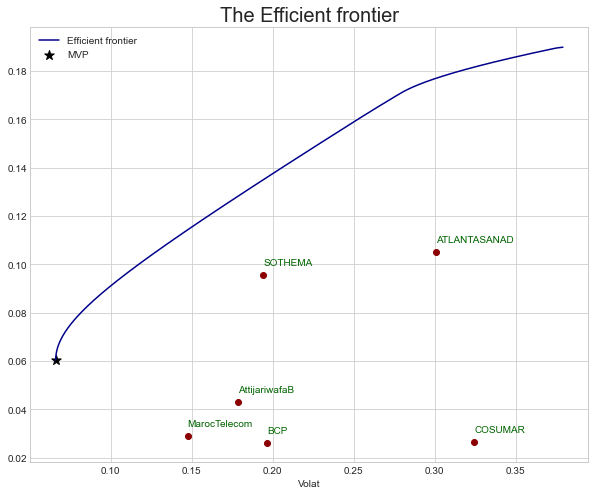

In [27]:
portfolios.plot(x='Volat', y='Expected_returns', color='darkblue', label='Efficient frontier')
plt.scatter(x=Volat.mean(), y=Expected_ret, color='darkred')
plt.scatter(x=mvp[1], y=mvp[0], color='black',s=100, marker='*' , label='MVP')
plt.legend()
plt.title('The Efficient frontier', fontsize=20)
for idx, instr in enumerate(list(Volat.columns)):
    plt.annotate(instr, (Volat.mean()[idx], Expected_ret[idx]+0.004), color='darkgreen')

In [28]:
# Now let's simulate 10000 portfolios in order to graph them in the Volatility-Expected rate of return space
p_ret_simul=[]
p_vol_simul=[]
p_weights_simul=[]
num_assets=n
num_portfolios=10000
for portfolio in range(num_portfolios):
    weights=np.random.random(num_assets)
    weights/=np.sum(weights)
    p_weights_simul.append(weights)
    returns=np.dot(weights, Expected_ret) 
    p_ret_simul.append(returns)
    
    var=LW_vcov.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd=np.sqrt(var)
    ann_sd=sd*np.sqrt(250)
    p_vol_simul.append(ann_sd)

bd_simul={'Expected_returns':p_ret_simul, 'Std':p_vol_simul}
for counter, symbol in enumerate(APR.columns.tolist()):
    bd_simul[symbol+' weights']=[w[counter] for w in p_weights_simul]

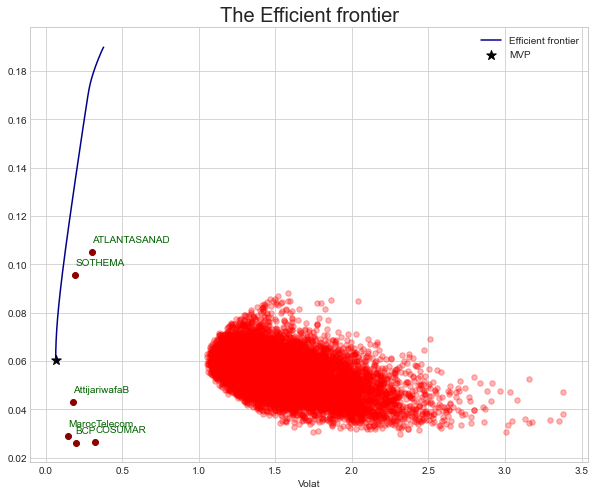

In [30]:
Simulated_portfolios=pd.DataFrame(bd_simul)
portfolios.plot(x='Volat', y='Expected_returns', color='darkblue', label='Efficient frontier')
plt.scatter(x=Volat.mean(), y=Expected_ret, color='darkred')
plt.scatter(x=mvp[1], y=mvp[0], color='black',s=100, marker='*' , label='MVP')
plt.scatter(x=Simulated_portfolios['Std'], y=Simulated_portfolios['Expected_returns'], color='red', alpha=0.3, s=30)
plt.legend()
plt.title('The Efficient frontier', fontsize=20)
for idx, instr in enumerate(list(Volat.columns)):
    plt.annotate(instr, (Volat.mean()[idx], Expected_ret[idx]+0.004), color='darkgreen')

# (Note that Simulated portfolios have positive weights, so Short-Selling was excluded for them)

# Final Note : Despite the use of low-variance estimators for the mean of asset's returns and their covariance matrix, The Markowitz model suffers from its unrealistic assumptions (frictionless economy, No transactions costs, Investors base their allocation on the mean and the variance (Returns are multivariate normal) ..) 